### 1. Load training/validation image dataset

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

data_root = './data/horse-or-human'

# define vectorize transformer
class VectorizeTransform:
    def __call__(self, img):
        return torch.reshape(img, (-1, ))

# compose image transformer
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    VectorizeTransform()    # for vectorizing input image
])

# load training dataset
train_data_path = data_root + '/train'
train_dataset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2048,
    shuffle=True,
    num_workers=0
)

# load validation dataset
valid_data_path = data_root + '/validation'
valid_dataset = torchvision.datasets.ImageFolder(root=valid_data_path, transform=transform)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=2048,
    shuffle=True,
    num_workers=0
)

### 2. Define model and functions for learning neural network

In [0]:
def sigmoid(z):
  return 1 / (1 + torch.exp(-z))

def loss(y_pred, y):
  epsilon = 1e-12
  return -1 * torch.mean(
      y * torch.log(y_pred + epsilon) + (1 - y) * torch.log(1 - y_pred + epsilon)
  )

def accuracy(y_pred, y):
  answer = (y_pred > 0.5).float()
  return torch.mean((answer == y).float())

class ThreeLayerNN:
  # initialize parameters for neural network
  def __init__(self, input_size, hidden1_size, hidden2_size, output_size, learning_rate, weight_init_std):
    self.results = {}
    self.params = {}

    self.params['w1'] = weight_init_std * torch.randn(hidden1_size, input_size)
    self.params['b1'] = torch.zeros((1, hidden1_size))
    
    self.params['w2'] = weight_init_std * torch.randn(hidden2_size, hidden1_size)
    self.params['b2'] = torch.zeros((1, hidden2_size))
    
    self.params['w3'] = weight_init_std * torch.randn(output_size, hidden2_size)
    self.params['b3'] = torch.zeros((1, output_size))

    self.lr = learning_rate

  # compute y prediction
  def predict(self, x):
    self.forward(x) # forward propagation
    pred = self.results['a3']

    return pred

  # compute gradients of each parameters and run the gradient descent algorithm
  def gradient_descent(self, x, y):
    # fetch model parameters
    w1, w2, w3 = self.params['w1'], self.params['w2'], self.params['w3']
    b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']

    self.forward(x) # forward propagation

    a0 = x
    # fetch forward propagation results
    a1, a2, a3 = self.results['a1'], self.results['a2'], self.results['a3']
    z1, z2, z3 = self.results['z1'], self.results['z2'], self.results['z3']

    batch_size = x.shape[0]

    # backward propagation
    dz3 = (a3 - y) / batch_size
    dw3 = torch.matmul(dz3.T, a2)
    db3 = torch.sum(dz3, axis=0)

    da2 = torch.matmul(dz3, w3)
    dz2 = a2 * (1 - a2) * da2
    dw2 = torch.matmul(dz2.T, a1)
    db2 = torch.sum(dz2, axis=0)

    da1 = torch.matmul(dz2, w2)
    dz1 = a1 * (1 - a1) * da1
    dw1 = torch.matmul(dz1.T, a0)
    db1 = torch.sum(dz1, axis=0)

    # update model parameters
    self.params['w1'] = w1 - self.lr * dw1
    self.params['b1'] = b1 - self.lr * db1
    self.params['w2'] = w2 - self.lr * dw2
    self.params['b2'] = b2 - self.lr * db2
    self.params['w3'] = w3 - self.lr * dw3
    self.params['b3'] = b3 - self.lr * db3

  # run forward propagation
  def forward(self, x):
    # fetch model parameters
    w1, w2, w3 = self.params['w1'], self.params['w2'], self.params['w3']
    b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']

    a0 = x

    z1 = torch.matmul(a0, w1.T) + b1
    a1 = sigmoid(z1)

    z2 = torch.matmul(a1, w2.T) + b2
    a2 = sigmoid(z2)

    z3 = torch.matmul(a2, w3.T) + b3
    a3 = sigmoid(z3)

    # store intermediate forward propagation results
    self.results['a1'], self.results['a2'], self.results['a3'] = a1, a2, a3
    self.results['z1'], self.results['z2'], self.results['z3'] = z1, z2, z3


### 3. Learning with the gradient descent algorithm


In [18]:
it = iter(train_loader)
images, labels = it.next()

train_data_count = len(train_loader.dataset)
valid_data_count = len(valid_loader.dataset)

# initialize parameters
epoch_count = 3000
learning_rate = 0.02
weight_init_std = 0.2

# create new neural network
nn = ThreeLayerNN(images.shape[1], 100, 50, 1, learning_rate, weight_init_std)

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

for epoch in range(epoch_count):
  # initialize current loss and accuracy
  mean_train_loss, mean_train_acc = 0, 0
  mean_valid_loss, mean_valid_acc = 0, 0

  # calculate train loss and accuracy at this epoch
  for batch_idx, (x_train, y_train) in enumerate(train_loader):
    batch_size = x_train.shape[0]

    y_train = torch.reshape(y_train, (batch_size, 1))
    y_pred_train = nn.predict(x_train)

    mean_train_loss += (batch_size / train_data_count) * loss(y_pred_train, y_train)
    mean_train_acc += (batch_size / train_data_count) * accuracy(y_pred_train, y_train)

  # calculate validation loss and accuracy at this epoch
  for batch_idx, (x_valid, y_valid) in enumerate(valid_loader):
    batch_size = x_valid.shape[0]

    y_valid = torch.reshape(y_valid, (batch_size, 1))
    y_pred_valid = nn.predict(x_valid)

    mean_valid_loss += (batch_size / valid_data_count) * loss(y_pred_valid, y_valid)
    mean_valid_acc += (batch_size / valid_data_count) * accuracy(y_pred_valid, y_valid)

  # run the gradient descent algorithm using train dataset at this epoch
  for batch_idx, (x_train, y_train) in enumerate(train_loader):
    batch_size = x_train.shape[0]

    y_train = torch.reshape(y_train, (batch_size, 1))
    nn.gradient_descent(x_train, y_train)

  # save losses and accuracies at this epoch
  train_losses.append(mean_train_loss)
  train_accs.append(mean_train_acc)
  valid_losses.append(mean_valid_loss)
  valid_accs.append(mean_valid_acc)

  if epoch % 100 == 0:
    print(f'epoch: {epoch}')
    print(f'train loss: {mean_train_loss}')
    print(f'train accuracy: {mean_train_acc}')
    print(f'validation loss: {mean_valid_loss}')
    print(f'validation accuracy: {mean_valid_acc}\n\n')


epoch: 0
train loss: 0.8019545078277588
train accuracy: 0.5131450891494751
validation loss: 0.8216551542282104
validation accuracy: 0.5


epoch: 100
train loss: 0.6742792725563049
train accuracy: 0.6407010555267334
validation loss: 0.686475932598114
validation accuracy: 0.5625


epoch: 200
train loss: 0.6610940098762512
train accuracy: 0.6728335022926331
validation loss: 0.6769860982894897
validation accuracy: 0.60546875


epoch: 300
train loss: 0.6489963531494141
train accuracy: 0.6903602480888367
validation loss: 0.6679670214653015
validation accuracy: 0.62109375


epoch: 400
train loss: 0.6348118782043457
train accuracy: 0.7039921879768372
validation loss: 0.6570942401885986
validation accuracy: 0.64453125


epoch: 500
train loss: 0.6180511116981506
train accuracy: 0.7117818593978882
validation loss: 0.6405330896377563
validation accuracy: 0.67578125


epoch: 600
train loss: 0.5975167751312256
train accuracy: 0.7341772317886353
validation loss: 0.6195318698883057
validation accuracy

### 4. Plot the outputs

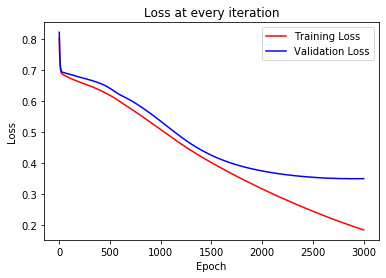

In [19]:
import matplotlib.pyplot as plt

# plot the training and validation loss at every epoch
epoch_count = range(1, len(train_losses) + 1)
plt.title('Loss at every iteration')
plt.plot(epoch_count, train_losses, 'r-')
plt.plot(epoch_count, valid_losses, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


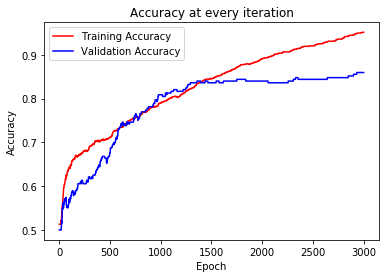

In [20]:
# plot the training and validation accuracy at every epoch
epoch_count = range(1, len(train_accs) + 1)
plt.title('Accuracy at every iteration')
plt.plot(epoch_count, train_accs, 'r-')
plt.plot(epoch_count, valid_accs, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


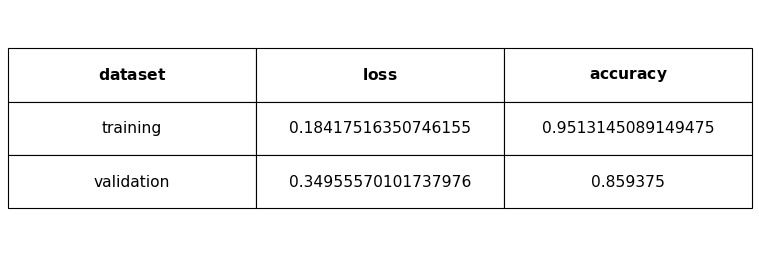

In [21]:
# present the table for the final accuracy and loss with training and validation datasets
fig = plt.figure(dpi=80)
ax = fig.add_subplot(1,1,1)

table_data=[
    ["$\\bf{dataset}$", "$\\bf{loss}$", "$\\bf{accuracy}$"],
    ["training", train_losses[-1].item(), train_accs[-1].item()],
    ["validation", valid_losses[-1].item(), valid_accs[-1].item()],
]

table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.set_fontsize(14)
table.scale(2,4)
ax.axis('off')

plt.show()
